In [1]:
import pickle


import arviz as az
import xarray as xr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.units import CodeUnits
from chainconsumer import Chain, ChainConsumer, Truth



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  

config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = False, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

## Langevine chains

In [4]:
with open('langevine_chains.pkl', 'rb') as f:
    out_samps_vmap = pickle.load(f)

EOFError: Ran out of input

In [ ]:
# Method 1: Using stack and unstack
def array_to_dataframe(arr):
    # Create MultiIndex for the reshaped data
    n_draws, n_params, n_chains = arr.shape
    
    # Reshape to (draws * chains, parameters)
    reshaped = arr.transpose(0, 2, 1).reshape(-1, n_params)
    
    # Create the multi-index
    draw_idx = np.tile(np.arange(n_draws), n_chains)
    chain_idx = np.repeat(np.arange(n_chains), n_draws)
    
    # Create DataFrame
    df = pd.DataFrame(reshaped, columns=['M_NFW', 't_end'])
    df['chain'] = chain_idx
    df['draw'] = draw_idx
    
    # Set the multi-index
    df = df.set_index(['chain', 'draw'])
    
    return df

df_multiple_chains = array_to_dataframe(jnp.array([list(i.values()) for i in out_samps_vmap]))
df_multiple_chains = df_multiple_chains.astype(float)  # Ensure all values are float
df_multiple_chains['M_NFW'] = 10**df_multiple_chains['M_NFW'] * code_units.code_mass.to(u.Msun)
df_multiple_chains['t_end'] = 10**df_multiple_chains['t_end'] * code_units.code_time.to(u.Gyr)
xdata_multiple_chains = xr.Dataset.from_dataframe(df_multiple_chains)

idata = az.InferenceData(posterior=xdata_multiple_chains)
idata

In [ ]:
c = ChainConsumer()
c.add_chain(Chain(samples=df_multiple_chains, name='Langevin samples'))
c.add_truth(Truth(location={'M_NFW': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end* code_units.code_time.to(u.Gyr)}), )
fig = c.plotter.plot()

In [ ]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata)
print("Monte Carlo Standard Error:")
print(mcse)

In [ ]:
# Plot running means to identify burn-in
def plot_running_mean(idata, var_names=None):
    if var_names is None:
        var_names = list(idata.posterior.data_vars)
    
    fig, axes = plt.subplots(len(var_names), 1, figsize=(10, 2*len(var_names)))
    if len(var_names) == 1:
        axes = [axes]
    
    for i, var in enumerate(var_names):
        samples = idata.posterior[var].values.flatten()
        running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)
        
        axes[i].plot(running_mean)
        axes[i].set_title(f'Running mean: {var}')
        axes[i].set_xlabel('Iteration')
        axes[i].set_ylabel('Running mean')
        
        # Add horizontal line at final mean
        axes[i].axhline(y=np.mean(samples), color='r', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_running_mean(idata)

# Alternative: Use ArviZ's built-in rank plot
az.plot_rank(idata, figsize=(12, 8))
plt.show()

In [ ]:
# Complete diagnostic analysis
def analyze_chains(idata, burn_in=0, thin=1):
    """Comprehensive chain analysis"""
    
    # Apply burn-in and thinning if needed
    if burn_in > 0 or thin > 1:
        idata_clean = idata.sel(draw=slice(burn_in, None, thin))
    else:
        idata_clean = idata
    
    print("=== CHAIN DIAGNOSTICS ===")
    
    # 1. Basic summary with R-hat
    summary = az.summary(idata_clean, hdi_prob=0.94)
    print("\nSummary Statistics:")
    print(summary)
    
    # 2. Convergence diagnostics
    print(f"\nR-hat values (should be < 1.1):")
    rhat = az.rhat(idata_clean)
    for var in rhat.data_vars:
        print(f"{var}: {float(rhat[var].values):.4f}")
    
    # 3. Effective sample size
    print(f"\nEffective Sample Size:")
    ess_bulk = az.ess(idata_clean, method="bulk")
    ess_tail = az.ess(idata_clean, method="tail")
    for var in ess_bulk.data_vars:
        print(f"{var} - Bulk: {int(ess_bulk[var].values)}, Tail: {int(ess_tail[var].values)}")
    
    # 4. Monte Carlo Standard Error
    print(f"\nMonte Carlo Standard Error:")
    mcse = az.mcse(idata_clean)
    for var in mcse.data_vars:
        print(f"{var}: {float(mcse[var].values):.6f}")
    
    return idata_clean, summary

# Run analysis
idata_clean, summary = analyze_chains(idata, burn_in=200, thin=2)

## MALA chains 

In [13]:
with open('mala_chains_2.pkl', 'rb') as f:
        state = pickle.load(f)

def mcmc_dict_to_dataframe(mcmc_dict):
    """
    Convert MCMC dictionary to DataFrame with chain and draw indices.
    
    Parameters:
    -----------
    mcmc_dict : dict
        Dictionary where keys are parameter names and values are arrays 
        of shape (n_chains, n_draws)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with MultiIndex (chain, draw) and parameter columns
    """
    
    # Get the first parameter to determine dimensions
    first_key = list(mcmc_dict.keys())[0]
    n_chains, n_draws = mcmc_dict[first_key].shape
    
    # Create arrays for indexing
    chain_idx = np.repeat(np.arange(n_chains), n_draws)
    draw_idx = np.tile(np.arange(n_draws), n_chains)
    
    # Create the base DataFrame with indices
    df_data = {
        'chain': chain_idx,
        'draw': draw_idx
    }
    
    # Add each parameter as a column
    for param_name, param_values in mcmc_dict.items():
        # Flatten the (n_chains, n_draws) array to (n_chains * n_draws,)
        df_data[param_name] = param_values.flatten()
    
    # Create DataFrame and set MultiIndex
    df = pd.DataFrame(df_data)
    df = df.set_index(['chain', 'draw'])
    
    return df

# Example usage with your data structure:
# Assuming you have something like:
# mcmc_results = {
#     'M_NFW': array_shape_(n_chains, n_draws),
#     't_end': array_shape_(n_chains, n_draws)
# }

# Convert to DataFrame
df_multiple_chains = mcmc_dict_to_dataframe(state)

In [14]:
df_multiple_chains

M_MN     M_NFW  M_plummer     t_end
chain draw                                         
0     0     7.114419  7.920989   0.330673  0.280673
      1     7.114419  7.920989   0.330673  0.280673
      2     7.114419  7.920989   0.330673  0.280673
      3     7.114419  7.920989   0.330673  0.280673
      4     7.114419  7.920989   0.330673  0.280673
...              ...       ...        ...       ...
1     495   7.126558  7.933129   0.342813  0.292813
      496   7.126558  7.933129   0.342813  0.292813
      497   7.126558  7.933129   0.342813  0.292813
      498   7.126558  7.933129   0.342813  0.292813
      499   7.126558  7.933129   0.342813  0.292813

[1000 rows x 4 columns]

In [15]:
df_multiple_chains['t_end']

chain  draw
0      0       0.280673
       1       0.280673
       2       0.280673
       3       0.280673
       4       0.280673
                 ...   
1      495     0.292813
       496     0.292813
       497     0.292813
       498     0.292813
       499     0.292813
Name: t_end, Length: 1000, dtype: float32

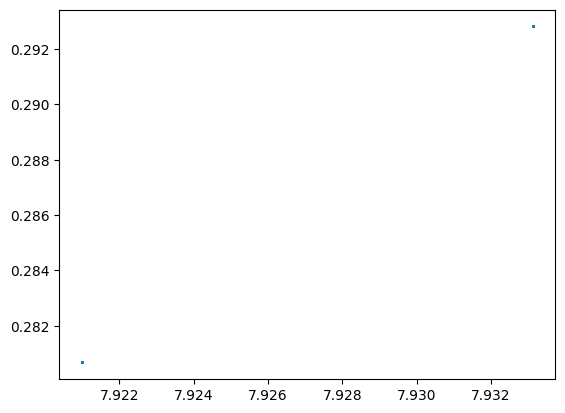

In [16]:
plt.scatter(df_multiple_chains['M_NFW'], df_multiple_chains['t_end'], s=1, alpha=0.1)

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/plotter.py:861: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(base.extents[p2])
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/plotter.py:860: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(base.extents[p1])
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


IndexError: index 0 is out of bounds for axis 0 with size 0

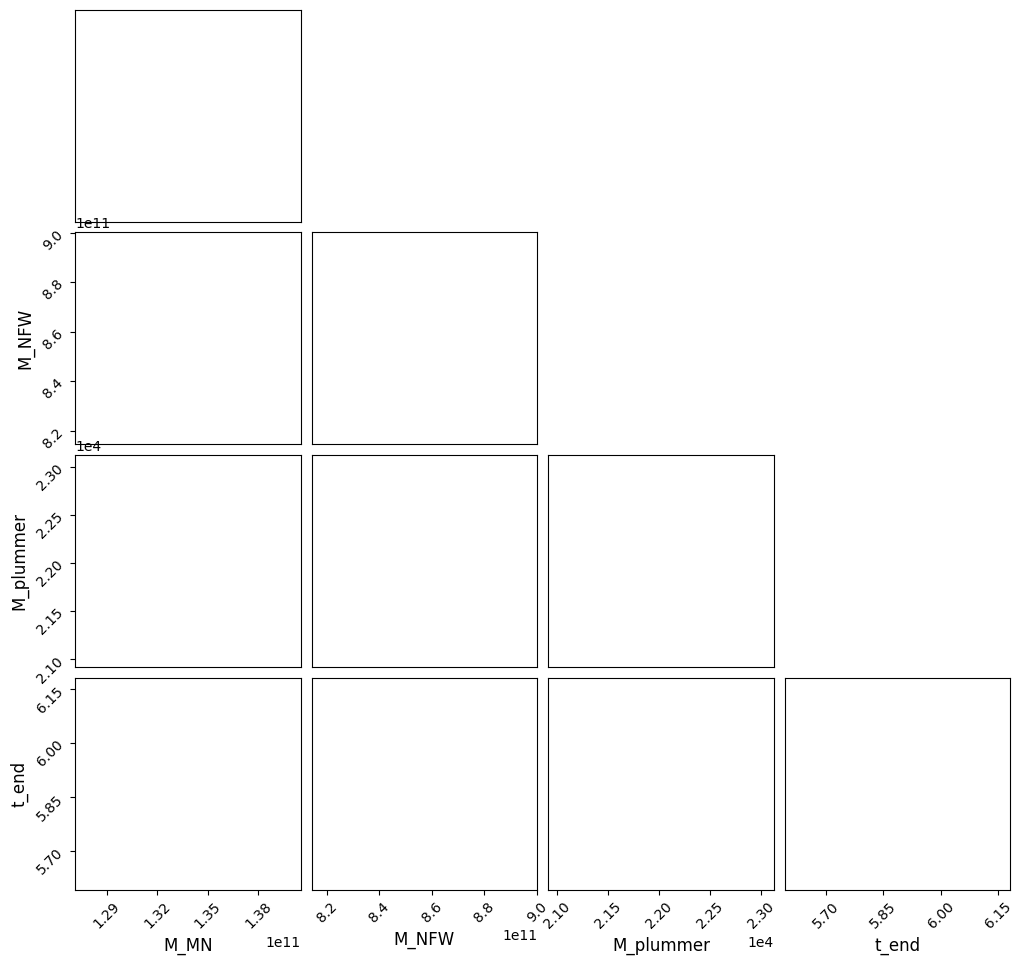

In [17]:
df_multiple_chains = df_multiple_chains.astype(float)  # Ensure all values are float
df_multiple_chains['M_NFW'] = 10**df_multiple_chains['M_NFW'] * code_units.code_mass.to(u.Msun)
df_multiple_chains['t_end'] = 10**df_multiple_chains['t_end'] * code_units.code_time.to(u.Gyr)
df_multiple_chains['M_plummer'] = 10**df_multiple_chains['M_plummer'] * code_units.code_mass.to(u.Msun)
df_multiple_chains['M_MN'] = 10**df_multiple_chains['M_MN'] * code_units.code_mass.to(u.Msun)
c = ChainConsumer()
c.add_chain(Chain(samples=df_multiple_chains, name='Langevin samples'))
c.add_truth(Truth(location={'M_NFW': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end * code_units.code_time.to(u.Gyr),
                            'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
                            'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun)}), )
fig = c.plotter.plot()

In [18]:
xdata = xr.Dataset.from_dataframe(df_multiple_chains)
idata = az.InferenceData(posterior=xdata)
idata

Inference data with groups:
	> posterior

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/diagnostics.py:992: RuntimeWarning: invalid value encountered in sqrt
  mcse_sd_value = np.sqrt(varsd)
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/export/home/vgiu

                   mean            sd        hdi_3%       hdi_97%  \
M_MN       1.319870e+11  1.845441e+09  1.301425e+11  1.338315e+11   
M_NFW      8.454757e+11  1.182236e+10  8.336592e+11  8.572921e+11   
M_plummer  2.171629e+04  3.036440e+02  2.141279e+04  2.201978e+04   
t_end      5.806000e+00  8.100000e-02  5.725000e+00  5.888000e+00   

              mcse_mean  mcse_sd  ess_bulk  ess_tail         r_hat  
M_MN       1.294442e+09      NaN       2.0    1000.0  9.898116e+15  
M_NFW      8.292526e+09   79.935       2.0       2.0  9.898116e+15  
M_plummer  2.129840e+02    0.000       2.0       2.0  9.898116e+15  
t_end      5.700000e-02    0.000       2.0       2.0  9.898116e+15  


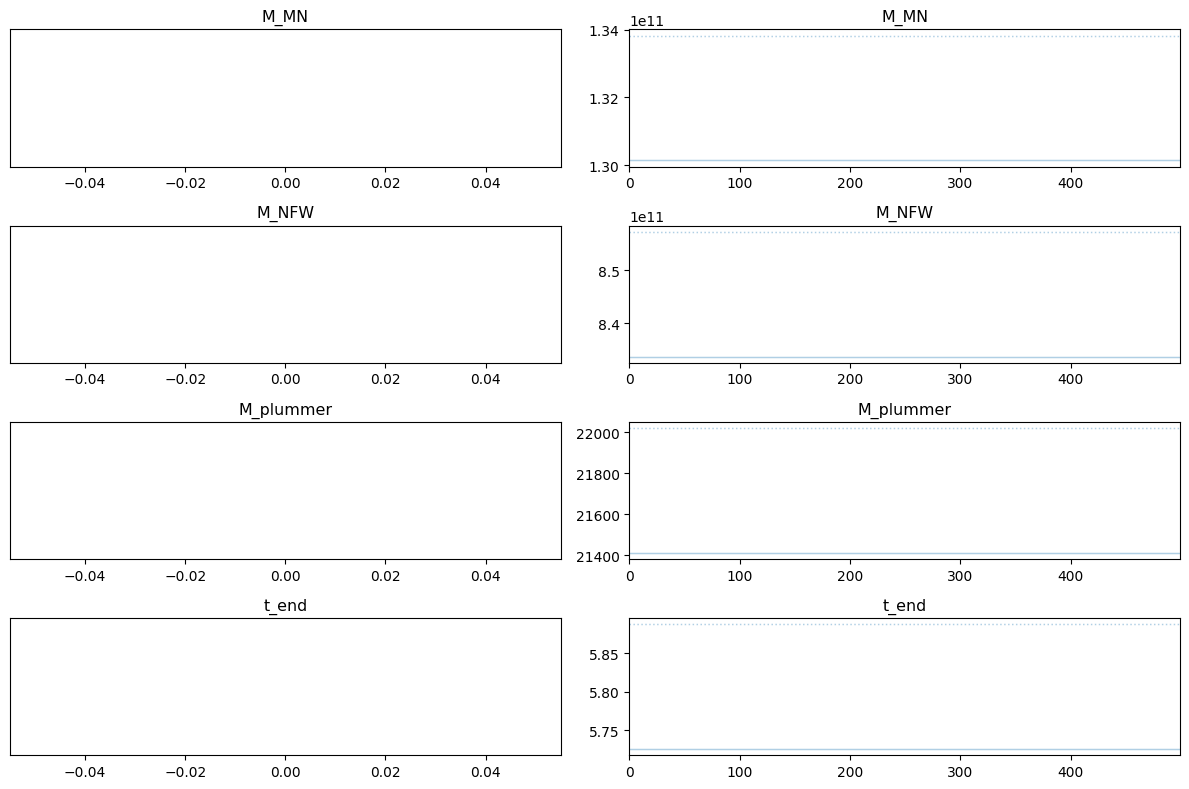

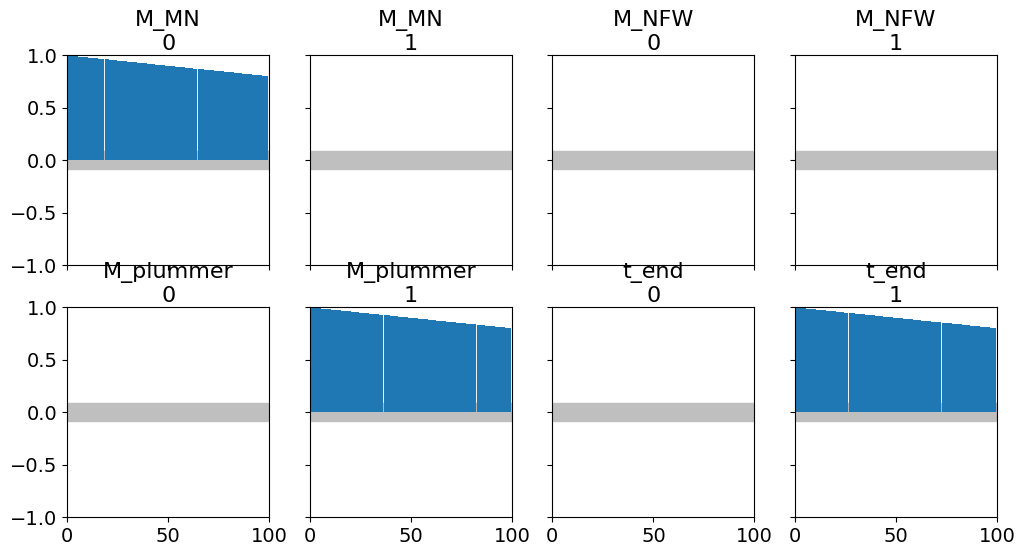

Effective Sample Size:
<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    M_MN       float64 8B 2.033
    M_NFW      float64 8B 2.033
    M_plummer  float64 8B 2.033
    t_end      float64 8B 2.033
Monte Carlo Standard Error:
<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    M_MN       float64 8B 1.294e+09
    M_NFW      float64 8B 8.293e+09
    M_plummer  float64 8B 213.0
    t_end      float64 8B 0.05695


In [19]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata)
print("Monte Carlo Standard Error:")
print(mcse)